## Evaluation and Uncertainty Analysis of Machine Learning Models for Classification Tasks

####  Author: Seyed.Kahaki@fda.hhs.gov, created on Sat Apr  1 09:48:11 2023

#### We used Delong method and Bootstrapping for estimating the confidence interval
##### DeLong method:
The DeLong method is a statistical method for estimating the confidence interval of the difference between the areas under the receiver operating characteristic (ROC) curves of two models. The ROC curve is a graphical representation of the trade-off between the true positive rate and the false positive rate for different threshold values of a binary classifier.

##### Bootstrapping:
This method involves resampling the data and calculating the model's performance metric of interest (e.g., accuracy, precision, recall) on each bootstrap sample. The distribution of the performance metric can be used to estimate the confidence interval.



#### General Imports

In [1]:
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score
import scipy.stats
from scipy import stats
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from keras.models import load_model
import os, os.path
import cv2
import glob
import pandas as pd
from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input
# from keras.preprocessing import image
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from datetime import datetime
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, f_regression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import pickle
import json
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from scipy.stats import norm
from sklearn.metrics import auc
import matplotlib.pyplot as plt

#### Define Functions

In [2]:
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
# Adopted from https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2

In [3]:
def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2

In [4]:
def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)

In [5]:
def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

In [6]:
def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

In [7]:
def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


In [8]:
def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight

In [9]:
def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

### Load Data

In [10]:
### Autoencoder Response Predition
Data_Dir = 'C:/Users/SeyedM.MousaviKahaki/OneDrive - FDA/007 Seyed_Reproducibility and Generalizability of AI_ML/01_OWH/Results/'
resultFile = 'Predict_Truth_AE_Resnet50_Random.xlsx'
# Read Results File
xls = pd.ExcelFile(Data_Dir+resultFile) # use r before absolute file path 
sheetX = xls.parse(0) #2 is the sheet number+1 thus if the file has only 1 sheet write 0 in paranthesis

In [11]:
## Get Results from excel file data
Random1 = sheetX['Predicted']
Random2 = sheetX['Predicted.1']
Random3 = sheetX['Predicted.2']
Random4 = sheetX['Predicted.3']
ResNet = sheetX['Predicted.4']
AE = sheetX['Predicted.5']
PS_High_Ranked = sheetX['Predicted.6']
PS_Low_Ranked = sheetX['Predicted.7']

Truth = sheetX['Truth']

In [12]:
## Autoencoder
y_pred = np.array(AE[2:25],dtype=float)
y_test = Truth[2:25]
tag = 'AE Model'

### Confusion Matrix, Precision, Recall

In [13]:
###############  Confusion matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_test.round(), y_pred.round(), labels=[1, 0]), 
    index=['true:yes', 'true:no'], 
    columns=['pred:yes', 'pred:no']
)
###############  Precision
precision = precision_score(y_test.round(), y_pred.round()) #  average=Nonefor precision from each class
############### Recall
recall = recall_score(y_test.round(), y_pred.round())
# ############### F1 score
f1_score1 = f1_score(y_test.round(), y_pred.round())
# ############### Cohen's kappa
cohen_kappa_score1 = cohen_kappa_score(y_test.round(), y_pred.round())

### Precision, Recall Confidence Interval

In [14]:
### Precision Recall Confidence Interval
#https://stackoverflow.com/questions/57482356/generating-confidence-interval-for-precision-recall-curve
# we'll need this for z-score


def ci_(tp, n, alpha=0.05):
    """ Estimates confidence interval for Bernoulli p
    Args:
      tp: number of positive outcomes, TP in this case
      n: number of attemps, TP+FP for Precision, TP+FN for Recall
      alpha: confidence level
    Returns:
      Tuple[float, float]: lower and upper bounds of the confidence interval
    """
    p_hat = float(tp) / n
    z_score = norm.isf(alpha * 0.5)  # two sides, so alpha/2 on each side
    variance_of_sum = p_hat * (1-p_hat) / n
    std = variance_of_sum ** 0.5
    return p_hat - z_score * std, p_hat + z_score * std


confusion_m = confusion_matrix(y_test.round(), y_pred.round())

TP = confusion_m[1][1]
FP = confusion_m[0][1]
TN = confusion_m[0][0]
FN = confusion_m[1][0]

n = TP+FP
Precision_CI = ci_(TP, n, alpha=0.05)

n = TP+FN
Recall_CI = ci_(TP, n, alpha=0.05)


### AUC 

In [15]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
# auc_keras = auc(recall, precision)

### Conficence Interval based on Delong Method

In [16]:
################ Delong
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

alpha = .95
# y_pred = y_pred0[:,0]#np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
# y_true = y_test#np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])

y_true = np.array(y_test)#np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])


auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

<ipython-input-6-541a4e51b4ac>:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
<ipython-input-6-541a4e51b4ac>:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
<ipython-input-6-541a4e51b4ac>:33: DeprecationWarning: `np.float` is a deprecated alias for the builti

### Bootstrap

Original ROC area: 0.794
Bootstrap #1 ROC area: 0.690
Bootstrap #2 ROC area: 0.784
Bootstrap #3 ROC area: 0.786
Bootstrap #4 ROC area: 0.811
Bootstrap #5 ROC area: 0.643
Bootstrap #6 ROC area: 0.569
Bootstrap #7 ROC area: 0.738
Bootstrap #8 ROC area: 0.768
Bootstrap #9 ROC area: 0.642
Bootstrap #10 ROC area: 0.931
Bootstrap #11 ROC area: 0.725
Bootstrap #12 ROC area: 0.857
Bootstrap #13 ROC area: 0.846
Bootstrap #14 ROC area: 0.924
Bootstrap #15 ROC area: 0.730
Bootstrap #16 ROC area: 0.696
Bootstrap #17 ROC area: 0.893
Bootstrap #18 ROC area: 0.759
Bootstrap #19 ROC area: 0.838
Bootstrap #20 ROC area: 0.829
Bootstrap #21 ROC area: 0.706
Bootstrap #22 ROC area: 0.530
Bootstrap #23 ROC area: 0.715
Bootstrap #24 ROC area: 0.908
Bootstrap #25 ROC area: 0.733
Bootstrap #26 ROC area: 0.667
Bootstrap #27 ROC area: 0.865
Bootstrap #28 ROC area: 0.889
Bootstrap #29 ROC area: 0.808
Bootstrap #30 ROC area: 0.925
Bootstrap #31 ROC area: 0.846
Bootstrap #32 ROC area: 0.708
Bootstrap #33 ROC area: 

Bootstrap #393 ROC area: 0.667
Bootstrap #394 ROC area: 0.921
Bootstrap #395 ROC area: 0.788
Bootstrap #396 ROC area: 0.738
Bootstrap #397 ROC area: 0.644
Bootstrap #398 ROC area: 0.776
Bootstrap #399 ROC area: 0.804
Bootstrap #400 ROC area: 0.950
Bootstrap #401 ROC area: 0.686
Bootstrap #402 ROC area: 0.843
Bootstrap #403 ROC area: 0.700
Bootstrap #404 ROC area: 0.826
Bootstrap #405 ROC area: 0.900
Bootstrap #406 ROC area: 0.615
Bootstrap #407 ROC area: 0.485
Bootstrap #408 ROC area: 0.722
Bootstrap #409 ROC area: 0.762
Bootstrap #410 ROC area: 0.873
Bootstrap #411 ROC area: 0.937
Bootstrap #412 ROC area: 0.754
Bootstrap #413 ROC area: 0.909
Bootstrap #414 ROC area: 0.625
Bootstrap #415 ROC area: 0.778
Bootstrap #416 ROC area: 0.674
Bootstrap #417 ROC area: 0.862
Bootstrap #418 ROC area: 0.608
Bootstrap #419 ROC area: 0.854
Bootstrap #420 ROC area: 0.777
Bootstrap #421 ROC area: 0.706
Bootstrap #422 ROC area: 0.838
Bootstrap #423 ROC area: 0.683
Bootstrap #424 ROC area: 0.759
Bootstra

Bootstrap #809 ROC area: 0.810
Bootstrap #810 ROC area: 0.843
Bootstrap #811 ROC area: 0.970
Bootstrap #812 ROC area: 0.746
Bootstrap #813 ROC area: 0.800
Bootstrap #814 ROC area: 0.608
Bootstrap #815 ROC area: 0.792
Bootstrap #816 ROC area: 0.792
Bootstrap #817 ROC area: 0.815
Bootstrap #818 ROC area: 0.893
Bootstrap #819 ROC area: 0.841
Bootstrap #820 ROC area: 0.657
Bootstrap #821 ROC area: 0.769
Bootstrap #822 ROC area: 0.857
Bootstrap #823 ROC area: 0.833
Bootstrap #824 ROC area: 0.925
Bootstrap #825 ROC area: 0.841
Bootstrap #826 ROC area: 0.884
Bootstrap #827 ROC area: 0.585
Bootstrap #828 ROC area: 0.929
Bootstrap #829 ROC area: 0.869
Bootstrap #830 ROC area: 0.812
Bootstrap #831 ROC area: 0.893
Bootstrap #832 ROC area: 0.897
Bootstrap #833 ROC area: 0.812
Bootstrap #834 ROC area: 0.867
Bootstrap #835 ROC area: 0.783
Bootstrap #836 ROC area: 0.908
Bootstrap #837 ROC area: 0.700
Bootstrap #838 ROC area: 0.708
Bootstrap #839 ROC area: 0.712
Bootstrap #840 ROC area: 0.867
Bootstra

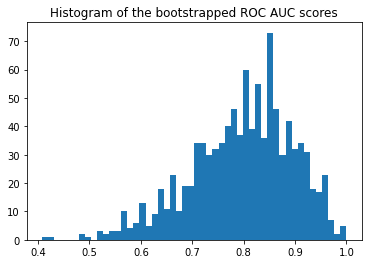

Bootstrap
Confidence interval for the score: [0.615 - 0.944]


In [17]:
y_true = np.array(y_test)#np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))


plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Bootstrap")
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

### Classification Report

In [18]:
########## Print All Together
print('####################')
print("Results for "+tag)
print(cmtx)
print("Precision: ",precision)
print("Precision_CI: ",Precision_CI)
print("Recall: ",recall)
print("Recall_CI: ",Recall_CI)
# print("F1 Score: ",f1_score1)
# print("Cohen_Kappa Score: ",cohen_kappa_score1)
print("Delong Method")
print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

####################
Results for AE Model
          pred:yes  pred:no
true:yes         9        5
true:no          2        7
Precision:  0.8181818181818182
Precision_CI:  (0.5902550587990167, 1.0461085775646197)
Recall:  0.6428571428571429
Recall_CI:  (0.3918637470442173, 0.8938505386700686)
Delong Method
AUC: 0.7936507936507936
AUC COV: 0.009001250072678645
95% AUC CI: [0.60769937 0.97960222]


### AUC Plot

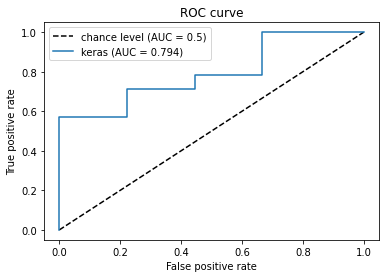

In [19]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label="chance level (AUC = 0.5)")
plt.plot(fpr_keras, tpr_keras, label='keras (AUC = {:.3f})'.format(auc_keras))
# plt.plot(precision, recall, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()